# Sentinel-1 explore rangelands dynamics
#### This notebook reads in Sentinel-1 analysis ready data (ARD) radar backscatter (Gamma nought) and dual-polarimetric decomposition (Alpha, Entropy and Anisotropy) for an area of interest in the rangelands area of Western Australia for one whole year. It also reads in Sentinel-2 ARD data and generates NDVI for comparing with the multitemporal trends of the Sentinel-1 (in this case it is the dual-pol Radar Vegetation Index (RVI) and Entropy bands). A grasslands mask (read in as a shape file) is then applied to extract only the areas of interest, before the monthly means are generated for the RVI and Entropy bands. These monthly means as well as the annual range in RVI and Entropy are then output as GeoTIFF files.

#### This notebook was written using the Virtual Desktop Infrastructure (VDI) on the National Computational Infrastructure (NCI), allowing access to the current Sentinel-1 and Digitial Earth Australia (DEA) ARD datasets. For this notebook to work you must first load the relevant modules:
-  module use /g/data/v10/public/modules/modulefiles
-  module load dea

#### as well create a radar.conf configuation file with the following information:
>  [default] <br>
>  db_hostname: agdcdev-db.nci.org.au <br>
>  dp_port: 6432 <br>
>  db_database:radar <br>

#### Note that Sentinel-1 is currently only processed to ARD and indexed into the datacube for portions of Australia. Three areas of interest are given in this notebook which covers areas where data already exists (including coverage of the grasslands mask shape file).

Author: Catherine Ticehurst

In [3]:
# Import relevant modules for this Jupyter Notebook
%pylab notebook

import datacube
import numpy as np
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt
from IPython.display import display
import ipywidgets as widgets

Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
dc = datacube.Datacube(config='radar.conf')

# View Product List & Details

In [3]:
dc.list_products()

name  \
id                                 
5                       dsm1sv10   
35   fc_percentile_albers_annual   
1             high_tide_comp_20p   
2           high_tide_comp_count   
12                       item_v2   
13                  item_v2_conf   
3              low_tide_comp_20p   
4            low_tide_comp_count   
6                  ls5_fc_albers   
37              ls5_level1_scene   
54               ls5_nbar_albers   
38                ls5_nbar_scene   
58              ls5_nbart_albers   
31    ls5_nbart_geomedian_annual   
39               ls5_nbart_scene   
50                 ls5_pq_albers   
41           ls5_pq_legacy_scene   
40                  ls5_pq_scene   
36  ls5_satellite_telemetry_data   
7                  ls7_fc_albers   
43              ls7_level1_scene   
57               ls7_nbar_albers   
44                ls7_nbar_scene   
51              ls7_nbart_albers   
30    ls7_nbart_geomedian_annual   
45               ls7_nbart_scene   
53                 ls7_pq_albers   
47           ls7_pq_legacy_scene   
46                  ls7_pq_scene   
42  ls7_satellite_telemetry_data   
..                           ...   
20                ls8_nbar_scene   
60              ls8_nbart_albers   
29    ls8_nbart_geomedian_annual   
56          ls8_nbart_oli_albers   
26           ls8_nbart_oli_scene   
21               ls8_nbart_scene   
55                 ls8_pq_albers   
28       ls8_pq_legacy_oli_scene   
23           ls8_pq_legacy_scene   
59             ls8_pq_oli_albers   
27              ls8_pq_oli_scene   
22                  ls8_pq_scene   
18  ls8_satellite_telemetry_data   
17  mangrove_extent_cover_albers   
15       pq_count_annual_summary   
32              pq_count_summary   
61               s1_gamma0_scene   
64           s1_gamma0_scene_odc   
65            s1_gamma0_scene_v2   
62              s1_haalpha_scene   
66         s1_haalpha_scene_test   
67        s1_haalpha_scene_test2   
33               s2a_ard_granule   
9            s2a_level1c_granule   
11           s2a_sen2cor_granule   
34               s2b_ard_granule   
10           s2b_level1c_granule   
48                   wofs_albers   
14         wofs_filtered_summary   
16                  wofs_summary   

                                          description  sat_path  \
id                                                                
5                                DSM 1sec Version 1.0       NaN   
35  Landsat Fractional Cover percentile 25 metre, ...       NaN   
1   High Tide 20 percentage composites for entire ...       NaN   
2                 High Tide 20 percentage pixel count       NaN   
12                           Intertidal Extents Model       NaN   
13                    Average ndwi Standard Deviation       NaN   
3   Low Tide 20 percentage composites for entire c...       NaN   
4                  Low Tide 20 percentage pixel count       NaN   
6   Landsat 5 Fractional Cover 25 metre, 100km til...       NaN   
37      Landsat 5 Level 1 At-sensor Radiance 25 metre       NaN   
54  Landsat 5 Surface Reflectance NBAR 25 metre, 1...       NaN   
38                            Landsat 5 NBAR 25 metre       NaN   
58  Landsat 5 Surface Reflectance NBART 25 metre, ...       NaN   
31  Surface Reflectance Geometric Median 25 metre,...       NaN   
39                           Landsat 5 NBART 25 metre       NaN   
50  Landsat 5 Pixel Quality 25 metre, 100km tile, ...       NaN   
41                       Landsat 5 PQ Legacy 25 metre       NaN   
40                              Landsat 5 PQ 25 metre       NaN   
36                 Landsat 5 Satellite Telemetry Data       NaN   
7   Landsat 7 Fractional Cover 25 metre, 100km til...       NaN   
43      Landsat 7 Level 1 At-sensor Radiance 25 metre       NaN   
57  Landsat 7 Surface Reflectance NBAR 25 metre, 1...       NaN   
44                            Landsat 7 NBAR 25 metre       NaN   
51  Landsat 7 Surface Reflectance NBART 25 metre, ...       NaN   
30  Surface Refle

# Load data over area of interest for year of interest 
>  Currently only use 2017 or 2018 for full years <br>
>  Note that the area of interest must be small to avoid memory issues

In [5]:
# Comment out areas not being used

Year = '2017'

query = {
# Area 1 - upper Fitzroy floodplain
'y': (-18.6, -18.4),
'x': (125.0, 125.2),

# Area 2 - SE of Fitzroy floodplain  
#'y': (-19.3, -19.1),
#'x': (125.3, 125.8),
    
# Area 3 - lower Fitzroy floodplain
#'y': (-18.6, -18.4),
#'x': (125.8, 126.0),
    
'time': (Year + '-01-01', Year + '-12-31'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (25, -25)
}

# Read radar backscatter

In [6]:
bs=dc.load(product='s1_gamma0_scene_v2', group_by='solar_day', **query)
bs

<xarray.Dataset>
Dimensions:  (time: 29, x: 891, y: 932)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-06T21:06:37.067738 ... 2017-12-20T21:06:46.267397
  * y        (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
  * x        (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
Data variables:
    vh       (time, y, x) float32 0.019936858 0.037450414 ... 0.017757092
    vv       (time, y, x) float32 0.024218239 0.10757342 ... 0.07893784
Attributes:
    crs:      EPSG: 3577

# Remove scenes that are mostly nulls
Uses code from https://github.com/fangfy/dea-projects/blob/master/water_interoperability/sentinel1_load_and_classify_nci.ipynb

In [7]:
# Identify images that have minimum nulls

total_px=len(bs.x)*len(bs.y)
valid=bs.where(bs.vv!=0).where(bs.vh!=0).count(dim=('x','y'))

good=(valid.vh/total_px)>0.5
good.sum()

<xarray.DataArray 'vh' ()>
array(29)

In [8]:
# Remove images that are mostly nulls

bs_good = bs.sel(time=good)
# replace 0 with nan
bs_clean = bs_good.where(bs_good!=0)
bs_clean

<xarray.Dataset>
Dimensions:  (time: 29, x: 891, y: 932)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-06T21:06:37.067738 ... 2017-12-20T21:06:46.267397
  * y        (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
  * x        (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
Data variables:
    vh       (time, y, x) float32 0.019936858 0.037450414 ... 0.017757092
    vv       (time, y, x) float32 0.024218239 0.10757342 ... 0.07893784
Attributes:
    crs:      EPSG: 3577

# Apply speckle filter to radar backscatter
Uses code from https://github.com/fangfy/dea-projects/blob/master/water_interoperability/sentinel1_load_and_classify_nci.ipynb

In [9]:
# Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [10]:
# Convert backscatter nans to 0 for lee filter

# save the nodata mask
nodata_mask = bs_clean.isnull().to_array().any(axis=0)
# replace nan with 0
bs_good_zerofilled = bs_good.where(~bs_good.isnull(), 0)
bs_good_zerofilled

<xarray.Dataset>
Dimensions:  (time: 29, x: 891, y: 932)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-06T21:06:37.067738 ... 2017-12-20T21:06:46.267397
  * y        (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
  * x        (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
Data variables:
    vh       (time, y, x) float32 0.019936858 0.037450414 ... 0.017757092
    vv       (time, y, x) float32 0.024218239 0.10757342 ... 0.07893784
Attributes:
    crs:      EPSG: 3577

In [11]:
# Apply speckle filter
smoothed_vv=bs_good_zerofilled.vv.groupby('time').apply(lee_filter, size=7)
smoothed_vh=bs_good_zerofilled.vh.groupby('time').apply(lee_filter, size=7)

In [12]:
# Create smoothed dataset with Nans and assign attributes
smoothed=smoothed_vv.to_dataset(name='vv')
smoothed['vh']=smoothed_vh
smoothed=smoothed.where(~nodata_mask)

In [13]:
# Remove unused data
bs_attrs = bs.attrs
smoothed = smoothed.assign_attrs(bs_attrs)

del bs, bs_good, bs_clean

<IPython.core.display.Javascript object>


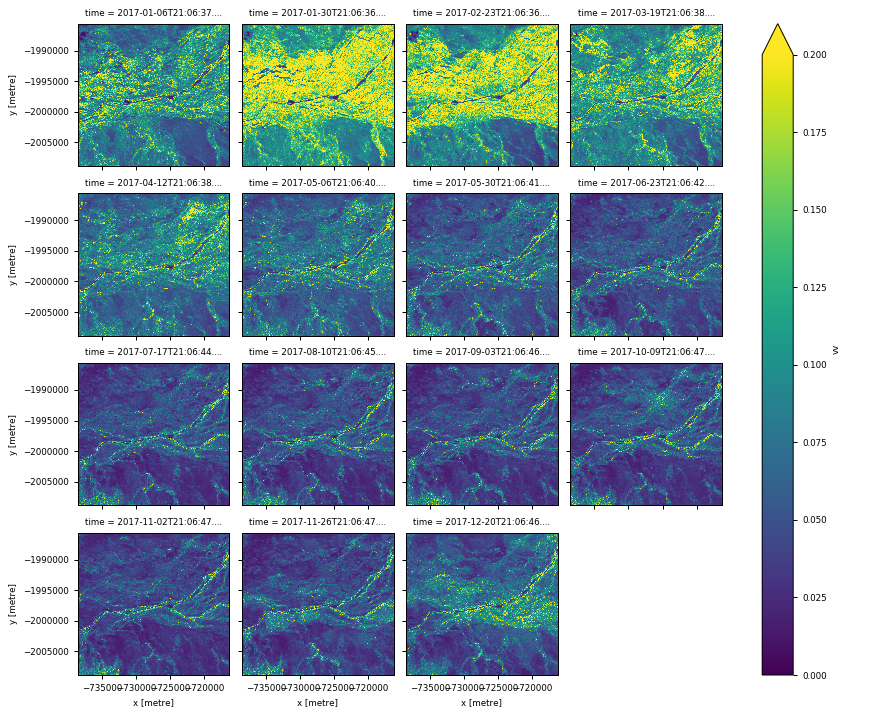

In [14]:
# View smoothed data (Note - you might need to edit 'figsize' to improve appearance)
pylab.rcParams['font.size']=7

ntimes=len(smoothed.time.values)
smoothed.vv.isel(time=slice(0,ntimes,2)).plot(col='time',col_wrap=4, vmin=0, vmax=0.2, figsize=(10,8))

In [16]:
# Calculate a modified dual-pol Radar Vegetation Index
smoothed['RVI'] = 4*smoothed.vh/(smoothed.vv + smoothed.vh)

<IPython.core.display.Javascript object>


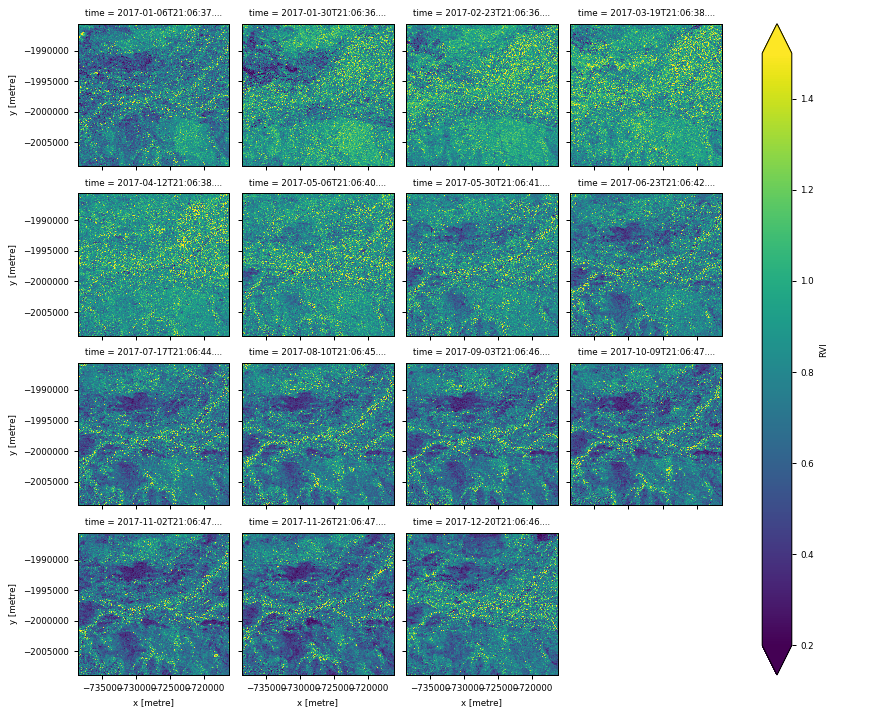

In [17]:
# View RVI data

ntimes=len(smoothed.time.values)
smoothed.RVI.isel(time=slice(0,ntimes,2)).plot(col='time',col_wrap=4, vmin=0.2, vmax=1.5, figsize=(10,8))

# Read in dual-pol decomp

In [18]:
dp=dc.load(product='s1_haalpha_scene', group_by='solar_day', **query)

In [19]:
# Remove any '0' null values

dp = dp.where(dp.entropy!=0)
dp

<xarray.Dataset>
Dimensions:     (time: 59, x: 891, y: 932)
Coordinates:
  * time        (time) datetime64[ns] 2017-01-06T21:06:37.194455 ... 2017-12-25T21:14:51.529181
  * y           (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
  * x           (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
Data variables:
    entropy     (time, y, x) float32 0.82229125 0.7376541 ... 0.85633445
    anisotropy  (time, y, x) float32 0.4847056 0.583905 ... 0.43876868
    alpha       (time, y, x) float32 58.153442 64.67583 ... 67.36098 59.55295
Attributes:
    crs:      EPSG: 3577

<IPython.core.display.Javascript object>


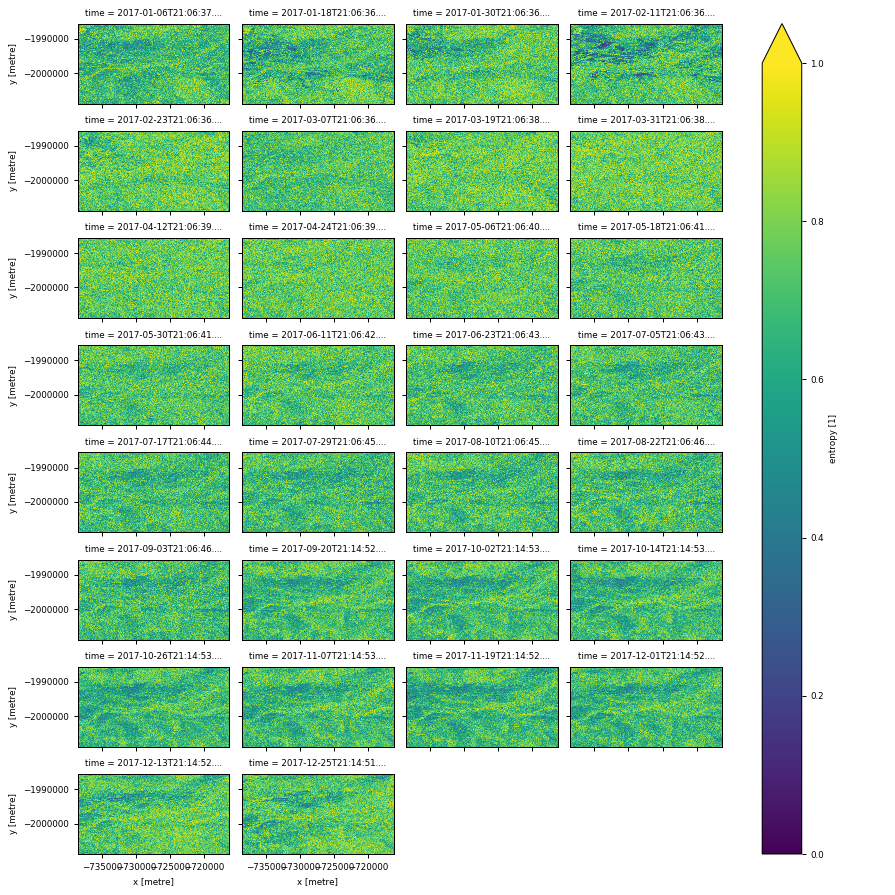

In [20]:
# View entropy (values range from 0-1.0) data 
# (can also change to look at 'alpha' (values ~40-80) or 'anisotropy' (values ~0-1.0))
ntimes=len(dp.time.values)
dp.entropy.isel(time=slice(0,ntimes,2)).plot(col='time',col_wrap=4, vmin=0, vmax=1.0, figsize=(10,10))

# Load Sentinel-2 to extract NDVI time series

In [24]:
dc_S2 = datacube.Datacube(app='dc-S2-extract')

In [25]:
# Read S2 green, nir and cloud mask bands for S2a and S2b
bands_of_interest = ['nbar_green', 'nbar_nir_2', 'fmask']
sensors = ['s2a','s2b']

s2 = {}
for sensor in sensors:
    s2[sensor] = dc_S2.load(product = sensor+'_ard_granule', group_by='solar_day', measurements = bands_of_interest, **query)
s2

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series(values.ravel())).reshape(values.shape)
/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/variable.py:134: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  return np.asarray(pd.Series

{'s2a': <xarray.Dataset>
 Dimensions:     (time: 37, x: 891, y: 932)
 Coordinates:
   * time        (time) datetime64[ns] 2017-01-01T01:56:12.026000 ... 2017-12-24T01:46:51.026000
   * y           (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
   * x           (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
 Data variables:
     nbar_green  (time, y, x) int16 782 830 787 810 820 ... -999 -999 -999 -999
     nbar_nir_2  (time, y, x) int16 2059 2102 2054 2027 ... -999 -999 -999 -999
     fmask       (time, y, x) uint8 3 3 3 3 3 3 3 3 3 3 3 ... 0 0 0 0 0 0 0 0 0 0
 Attributes:
     crs:      EPSG: 3577, 's2b': <xarray.Dataset>
 Dimensions:     (time: 24, x: 891, y: 932)
 Coordinates:
   * time        (time) datetime64[ns] 2017-07-05T01:57:29.027000 ... 2017-12-29T01:46:49.027000
   * y           (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
   * x           (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
 Data variables:
     nbar_green  

## Can also view current DEA product list

In [23]:
products = dc_S2.list_products()
products

NameError: name 'dc_S2' is not defined

In [26]:
# Combine the S2a and S2b dates
s2_clean = xr.concat(s2.values(), dim='time')

del s2

<IPython.core.display.Javascript object>


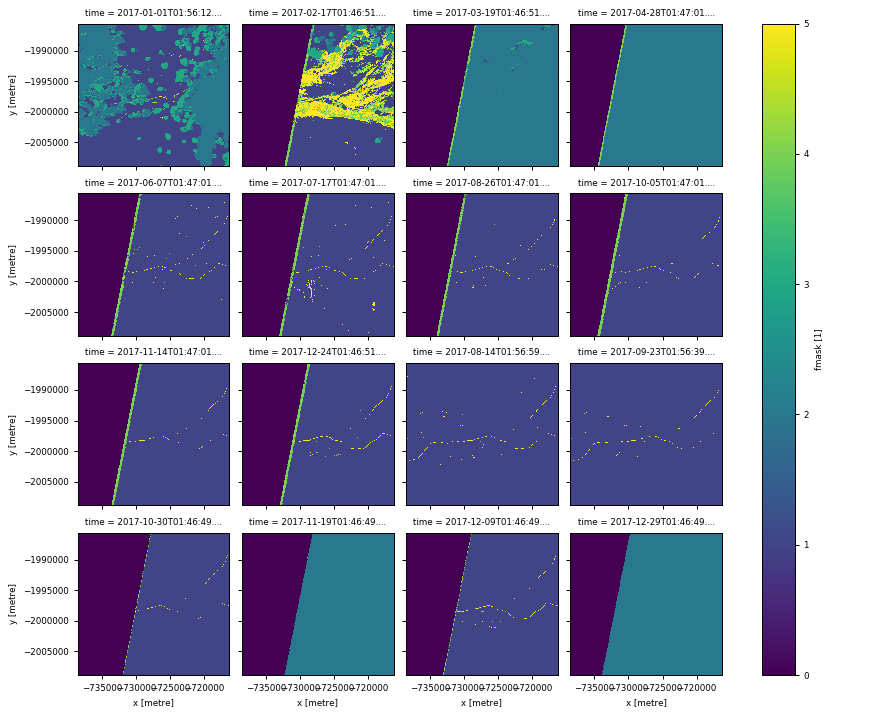

In [27]:
# View the S2 fmask
ntimes=len(s2_clean.time.values)
s2_clean.fmask.isel(time=slice(0,ntimes,4)).plot(col='time', col_wrap=4, figsize=(10,8))

In [28]:
# Remove clouds and nulls from S2 data
nbar_green = s2_clean.nbar_green
s2_good=nbar_green.to_dataset(name='green')
s2_good['nir']=s2_clean.nbar_nir_2
s2_good['fmask']=s2_clean.fmask

s2_good_temp = s2_good.where(s2_good.fmask<2) # to remove cloud/shadow/nulls based on fmask
s2_good_clean = s2_good_temp.where(s2_good_temp.fmask!=0)

s2_good_clean = s2_good_clean.assign_attrs(bs_attrs)

del s2_good
s2_good_clean

<xarray.Dataset>
Dimensions:  (time: 61, x: 891, y: 932)
Coordinates:
  * y        (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
  * x        (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
  * time     (time) datetime64[ns] 2017-01-01T01:56:12.026000 ... 2017-12-29T01:46:49.027000
Data variables:
    green    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    nir      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    fmask    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG: 3577

In [29]:
# Create NDVI band
s2_good_clean['ndvi']=(s2_good_clean.nir.astype(float) - s2_good_clean.green.astype(float))/(s2_good_clean.nir.astype(float) + s2_good_clean.green.astype(float))

# Remove any remaining erroneous values (where NDVI <-1.0 and NDVI > 1.0)
s2_good_clean = s2_good_clean.where(s2_good_clean.ndvi > -1.0).where(s2_good_clean.ndvi < 1.0)

<IPython.core.display.Javascript object>


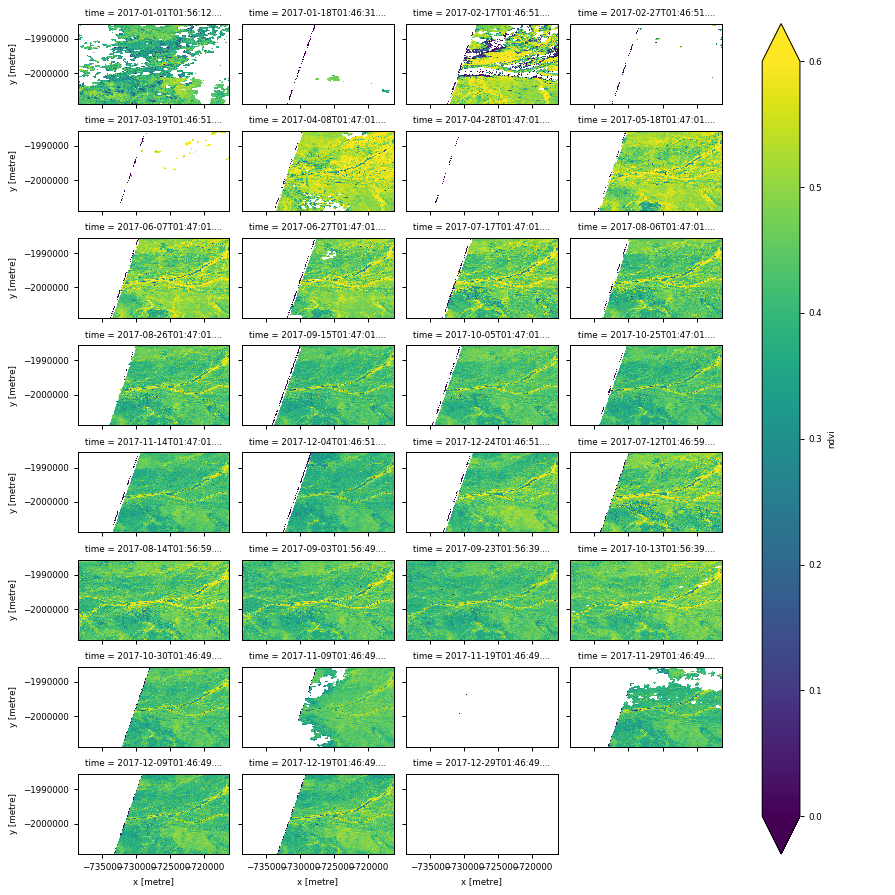

In [30]:
# View S2 NDVI time series
ntimes=len(s2_good_clean.time.values)
s2_good_clean.isel(time=slice(0,ntimes,2)).ndvi.plot(col='time', col_wrap=4, vmin=0.0, vmax=0.6, figsize=(10,10))

# Select area of interest interactively to look at RVI, Entropy and NDVI time series

In [36]:
def onclick(event):
    global pixelx, pixely
    x, y = int(event.xdata), int(event.ydata)
    image_coords = smoothed.affine * (x, y)
    pixelx = x 
    pixely = y 
    w.value = 'pixelx : {}, pixely : {}'.format(pixelx, pixely)

Click on the pixel to view its time series below


<IPython.core.display.Javascript object>


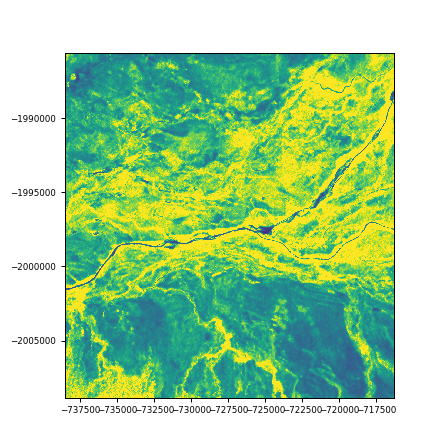

HTML(value='Click on the pixel to view its time series below')

In [37]:
print('\033[1m' + 'Click on the pixel to view its time series below' + '\033[0m')

fig = plt.figure(figsize = (5,5))
plt.imshow(np.flip(smoothed.vv.mean(dim='time')), interpolation = 'nearest', clim=(0,0.1), extent=[smoothed.coords['x'].min(), smoothed.coords['x'].max(), smoothed.coords['y'].min(), smoothed.coords['y'].max()]) 

w = widgets.HTML("Click on the pixel to view its time series below")

cid = fig.canvas.mpl_connect('button_press_event', onclick)
display(w)

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


<IPython.core.display.Javascript object>


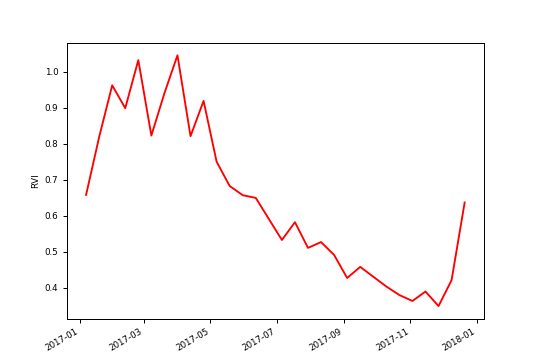

<IPython.core.display.Javascript object>


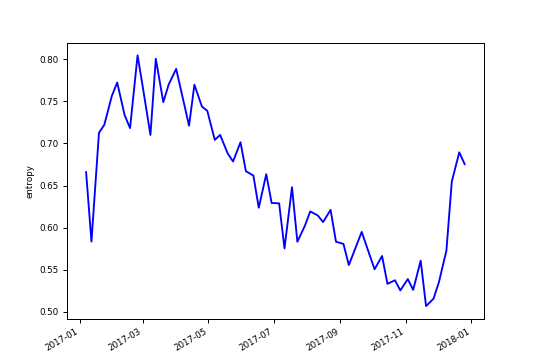

/g/data/v10/public/modules/dea-env/20190329/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<IPython.core.display.Javascript object>


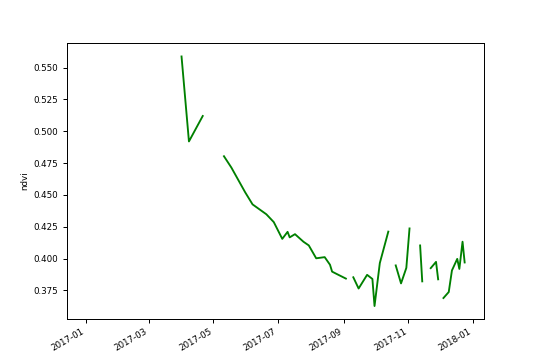

('for point :', slice(-730398, -730598, None), slice(-2004830, -2004630, None))

In [38]:
# plot RVI, Entropy and NDVI through time based on the x,y point selected
from matplotlib import pyplot as plt

# expand selected x,y pixel to make a square area of interest
xp, yp=slice(pixelx+100,pixelx-100), slice(pixely-100,pixely+100)

(smoothed.sel(x=xp,y=yp).RVI.groupby('time').mean()).plot(color='r', figsize=(6,4))
(dp.sel(x=xp,y=yp).entropy.groupby('time').mean()).plot(color='b', figsize=(6,4))
(s2_good_clean.sel(x=xp,y=yp).ndvi.groupby('time').mean()).plot(color='g', figsize=(6,4))
'for point :', xp, yp

# Show Annual Statistics|

<IPython.core.display.Javascript object>


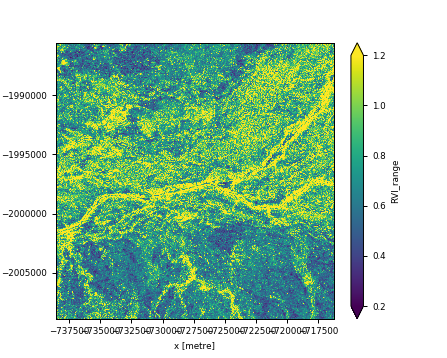

<IPython.core.display.Javascript object>


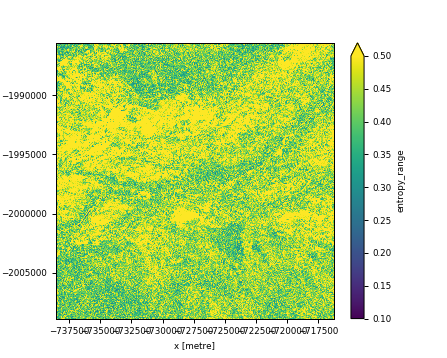

<IPython.core.display.Javascript object>


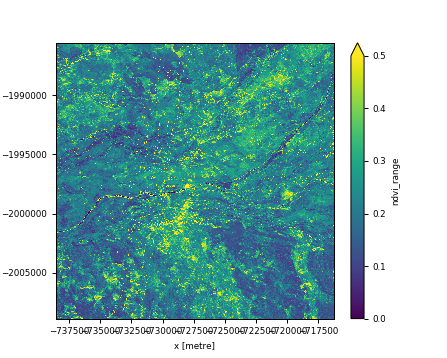

In [39]:
# Calculate annual range (max minus min) for radar backscatter RVI, dul-pol decomposition Entropy, and NDVI
from matplotlib import pyplot as plt

smoothed['RVI_range'] = smoothed.RVI.max(dim='time') - smoothed.RVI.min(dim='time')
dp['entropy_range'] = dp.entropy.max(dim='time') - dp.entropy.min(dim='time')
s2_good_clean['ndvi_range'] = s2_good_clean.ndvi.max(dim='time') - s2_good_clean.ndvi.min(dim='time')

smoothed.RVI_range.plot(vmin=0.2,vmax=1.2, figsize =(5,4))
dp.entropy_range.plot(vmin=0.1,vmax=0.5, figsize =(5,4))
s2_good_clean.ndvi_range.plot(vmin=0.0,vmax=0.5, figsize =(5,4))

<IPython.core.display.Javascript object>


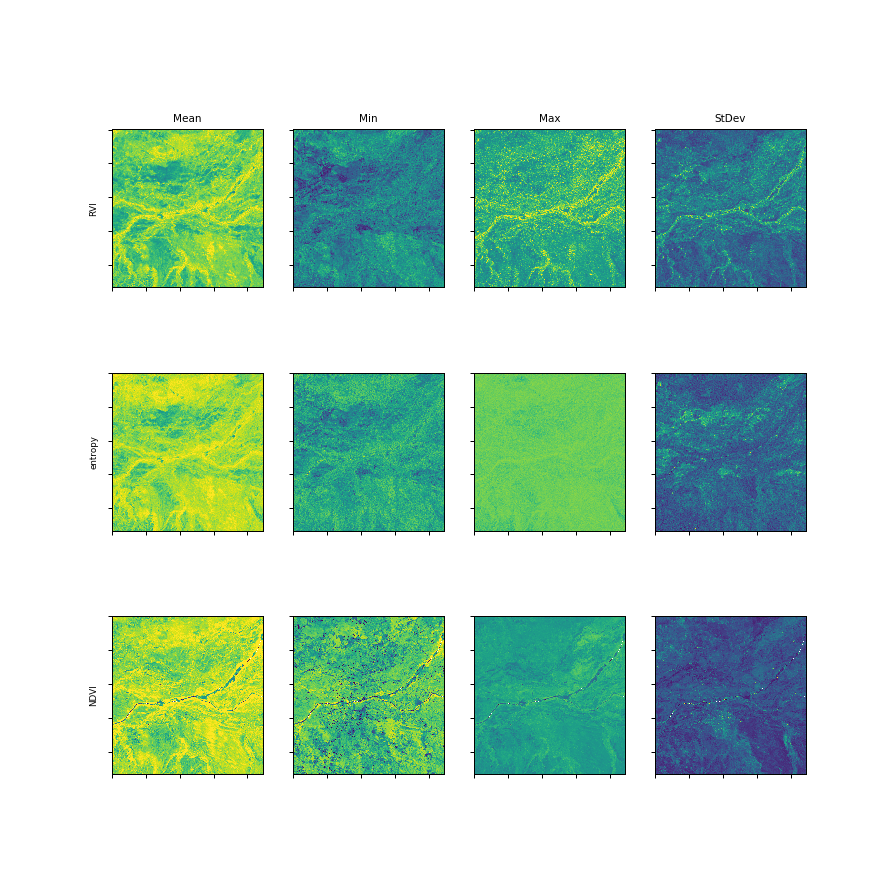

[]

In [40]:
# Show RVI, Entropy and NDVI mean, min, max and stand deviation for current year
# (note that to display as numpy images it needs to be flipped)

RVI_mean = np.flip(smoothed.RVI.mean(dim='time'))
RVI_min = np.flip(smoothed.RVI.min(dim='time'))
RVI_max = np.flip(smoothed.RVI.max(dim='time'))
RVI_std = np.flip(smoothed.RVI.std(dim='time'))

entropy_mean = np.flip(dp.entropy.mean(dim='time'))
entropy_min = np.flip(dp.entropy.min(dim='time'))
entropy_max = np.flip(dp.entropy.max(dim='time'))
entropy_std = np.flip(dp.entropy.std(dim='time'))

NDVI_mean = np.flip(s2_good_clean.ndvi.mean(dim='time'))
NDVI_min = np.flip(s2_good_clean.ndvi.min(dim='time'))
NDVI_max = np.flip(s2_good_clean.ndvi.max(dim='time'))
NDVI_std = np.flip(s2_good_clean.ndvi.std(dim='time'))

fix, ax = plt.subplots(3,4, figsize=(10,10))
ax[0,0].imshow(RVI_mean, clim=(0,1.0))
ax[0,0].set_title('Mean')
ax[0,0].set_ylabel('RVI')
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
ax[0,1].imshow(RVI_min, clim=(0,1.0))
ax[0,1].set_title('Min')
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,2].imshow(RVI_max, clim=(0,2.0))
ax[0,2].set_title('Max')
ax[0,2].set_xticklabels([])
ax[0,2].set_yticklabels([])
ax[0,3].imshow(RVI_std, clim=(0,0.5))
ax[0,3].set_title('StDev')
ax[0,3].set_xticklabels([])
ax[0,3].set_yticklabels([])
ax[1,0].imshow(entropy_mean, clim=(0.2,0.8))
ax[1,0].set_ylabel('entropy')
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])
ax[1,1].imshow(entropy_min, clim=(0,0.8))
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
ax[1,2].imshow(entropy_max, clim=(0,1.2))
ax[1,2].set_xticklabels([])
ax[1,2].set_yticklabels([])
ax[1,3].imshow(entropy_std, clim=(0.05,0.2))
ax[1,3].set_xticklabels([])
ax[1,3].set_yticklabels([])
ax[2,0].imshow(NDVI_mean, clim=(0.1,0.5))
ax[2,0].set_ylabel('NDVI')
ax[2,0].set_xticklabels([])
ax[2,0].set_yticklabels([])
ax[2,1].imshow(NDVI_min, clim=(0,0.5))
ax[2,1].set_xticklabels([])
ax[2,1].set_yticklabels([])
ax[2,2].imshow(NDVI_max, clim=(0,1.0))
ax[2,2].set_xticklabels([])
ax[2,2].set_yticklabels([])
ax[2,3].imshow(NDVI_std, clim=(0,0.2))
ax[2,3].set_xticklabels([])
ax[2,3].set_yticklabels([])

# Apply grassland mask to images

<IPython.core.display.Javascript object>


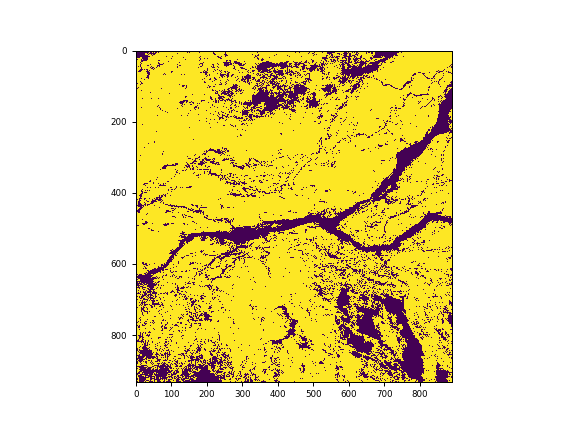

In [41]:
import ogr, gdal, osr

# Define pixel size (keep same as original) and NoData value of new raster
xres = 25 
yres = 25 
NoData_value = 0

# Filename of grassland mask shape file for current area 
# (Note -there will be errors if it doesnt cover the current area)
vector_fn = '/home/599/cjt599/Demo_files/Area_Shapefiles/fromglc10v01_-20_124_GrasslandMask_25m_Seg100_Area1_Mask_Grassland.shp'

# set the geotransform properties
xcoords = smoothed.isel(time=1).vv.indexes['x'] 
ycoords = smoothed.isel(time=1).vv.indexes['y'] 
MaxValX = xcoords.shape
MaxValY = ycoords.shape
geotransform = (xcoords[MaxValX[0]-1]-(xres*0.5), xres, 0, ycoords[MaxValY[0]-1]+(yres*0.5), 0, -yres)

# Open the data source and read in the extent
source_ds = ogr.Open(vector_fn)
source_layer = source_ds.GetLayer()
source_srs = source_layer.GetSpatialRef()
vx_min, vx_max, vy_min, vy_max = source_layer.GetExtent() # this is extent of Australia

# Create the destination extent
arr_aoi = smoothed.vv.isel(time =1)
arr_aoi.shape
yt,xt = arr_aoi.shape # to be the same size as SAR images

# set up mask image including projection
target_ds = gdal.GetDriverByName('MEM').Create('', xt, yt, gdal.GDT_Byte)
target_ds.SetGeoTransform(geotransform) # this is the same as the NDVI diff LL geoTIFF
latlon = osr.SpatialReference() # establish encoding
latlon.ImportFromEPSG(3577) # to projection (4326 or 3577)
target_ds.SetProjection(latlon.ExportToWkt()) # export coords to file
band = target_ds.GetRasterBand(1)
band.SetNoDataValue(NoData_value)

# rasterise
gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[1])

# Read as mask array and view
Mask_array = band.ReadAsArray()

fig = plt.figure()
plt.imshow(Mask_array)

<IPython.core.display.Javascript object>


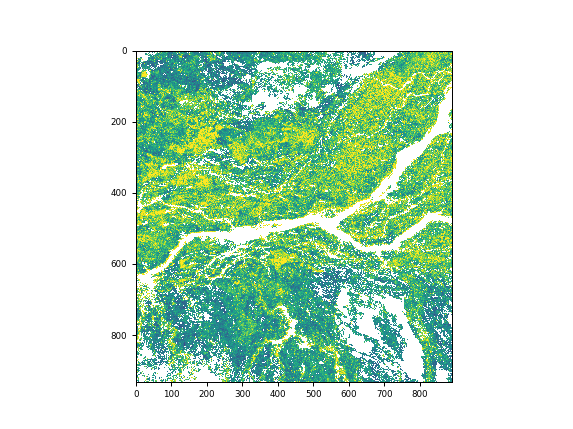

In [42]:
# Apply grassland mask to the RVI (note you need to np.flip image for xarray/numpy conversion)

smoothed_grassland = smoothed.where(np.flip(Mask_array==1))

fig = plt.figure()
plt.imshow(np.flip(smoothed_grassland.RVI_range), clim=(0,1.2))

<IPython.core.display.Javascript object>


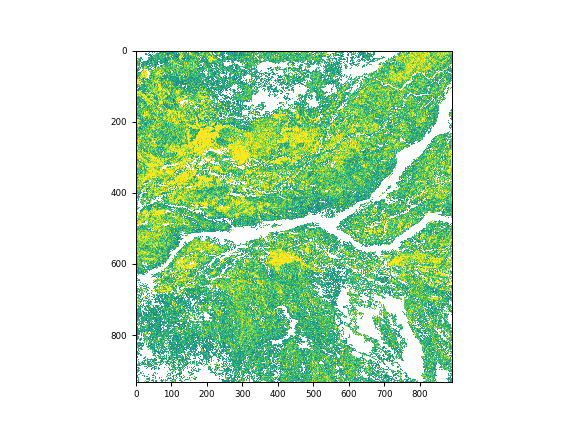

In [43]:
# Apply grassland mask to the entropy (note you need to np.flip image for xarray/numpy conversion)

dp_grassland = dp.where(np.flip(Mask_array==1))

fig = plt.figure()
plt.imshow(np.flip(dp_grassland.entropy_range), clim=(0.1,0.6))

<IPython.core.display.Javascript object>


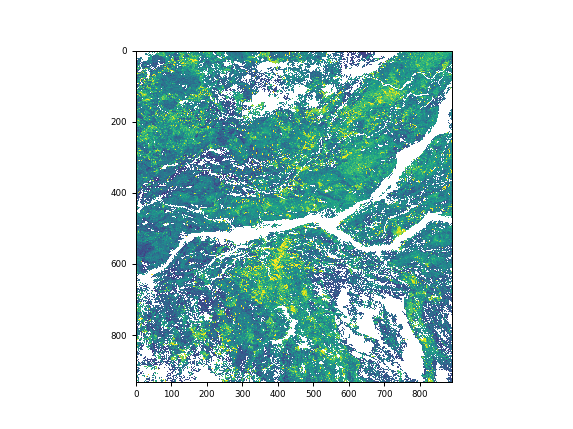

In [44]:
# Apply grassland mask to the NDVI  scene (note you need to np.flip image for xarray/numpy conversion)

s2_good_clean_grassland = s2_good_clean.where(np.flip(Mask_array==1))

fig = plt.figure()
plt.imshow(np.flip(s2_good_clean_grassland.ndvi_range), clim=(0,0.5))

## Calculate monthly mean RVI images for grasslands

<IPython.core.display.Javascript object>


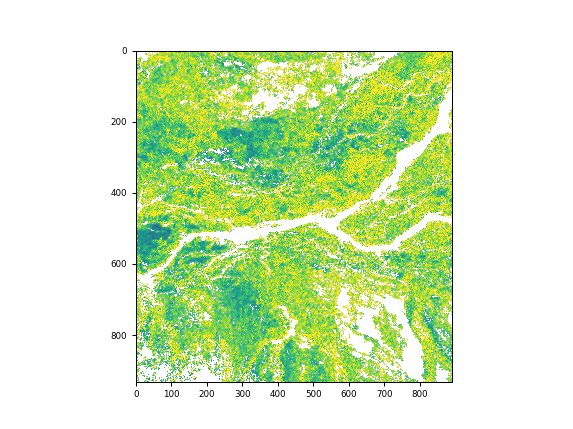

<xarray.Dataset>
Dimensions:  (time: 12, x: 891, y: 932)
Coordinates:
  * y        (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
  * x        (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
  * time     (time) datetime64[ns] 2017-01-01 2017-02-01 ... 2017-12-01
Data variables:
    Jan      (y, x) float32 1.0828631 1.0822715 nan 1.0183859 ... nan nan nan
    Feb      (y, x) float32 1.088094 1.086407 nan 0.9164876 ... nan nan nan nan
    Mar      (y, x) float32 0.9735829 0.9310129 nan 0.9004112 ... nan nan nan
    Apr      (y, x) float32 0.7331759 0.78811383 nan 0.9172054 ... nan nan nan
    May      (y, x) float32 0.71320754 0.73715806 nan 0.8314424 ... nan nan nan
    Jun      (y, x) float32 0.751971 0.77400374 nan 0.8018084 ... nan nan nan
    Jul      (y, x) float32 0.7490688 0.6885681 nan 0.63501465 ... nan nan nan
    Aug      (y, x) float32 0.5762946 0.6659124 nan 0.55772144 ... nan nan nan
    Sep      (y, x) float32 0.60966074 0.64811695 nan 0.63911605 

In [45]:
import pandas as pd
time = pd.to_datetime(['2017-01-01','2017-02-01','2017-03-01','2017-04-01','2017-05-01','2017-06-01',
                             '2017-07-01','2017-08-01','2017-09-01','2017-10-01','2017-11-01','2017-12-01'])

monthly_mean_RVI=xr.Dataset({'Jan':(smoothed_grassland.RVI.sel(time=slice('2017-01-01', '2017-01-31')).mean(dim='time')), 'time': time})
monthly_mean_RVI['Feb']=smoothed_grassland.RVI.sel(time=slice('2017-02-01', '2017-02-28')).mean(dim='time')
monthly_mean_RVI['Mar']=smoothed_grassland.RVI.sel(time=slice('2017-03-01', '2017-03-31')).mean(dim='time')
monthly_mean_RVI['Apr']=smoothed_grassland.RVI.sel(time=slice('2017-04-01', '2017-04-30')).mean(dim='time')
monthly_mean_RVI['May']=smoothed_grassland.RVI.sel(time=slice('2017-05-01', '2017-05-31')).mean(dim='time')
monthly_mean_RVI['Jun']=smoothed_grassland.RVI.sel(time=slice('2017-06-01', '2017-06-30')).mean(dim='time')
monthly_mean_RVI['Jul']=smoothed_grassland.RVI.sel(time=slice('2017-07-01', '2017-07-31')).mean(dim='time')
monthly_mean_RVI['Aug']=smoothed_grassland.RVI.sel(time=slice('2017-08-01', '2017-08-31')).mean(dim='time')
monthly_mean_RVI['Sep']=smoothed_grassland.RVI.sel(time=slice('2017-09-01', '2017-09-30')).mean(dim='time')
monthly_mean_RVI['Oct']=smoothed_grassland.RVI.sel(time=slice('2017-10-01', '2017-10-31')).mean(dim='time')
monthly_mean_RVI['Nov']=smoothed_grassland.RVI.sel(time=slice('2017-11-01', '2017-11-30')).mean(dim='time')
monthly_mean_RVI['Dec']=smoothed_grassland.RVI.sel(time=slice('2017-12-01', '2017-12-31')).mean(dim='time')

monthly_mean_RVI = monthly_mean_RVI.assign_attrs(bs_attrs)

# Display a monthly mean
fig = plt.figure()
plt.imshow(np.flip(monthly_mean_RVI.May), clim=(0,1.0))
monthly_mean_RVI

In [2]:
# Find date of minimum RVI **************** DOESNT WORK **************************

import pandas as pd
time = pd.to_datetime(['2017-01-01','2017-02-01','2017-03-01','2017-04-01','2017-05-01','2017-06-01',
                             '2017-07-01','2017-08-01','2017-09-01','2017-10-01','2017-11-01','2017-12-01'])

x = smoothed_grassland.isel(time=1).RVI.indexes['x']
y = smoothed_grassland.isel(time=1).RVI.indexes['y']

MM_RVI=xr.Dataset({})
MM_RVI['time'] = time

#MM_RVI = xr.Dataset(coords={'time': time, 'y': y, 'x', x}, dims=['time','x','y'])
#MM_RVI = MM_RVI.assign_attrs(bs_attrs)

MM_RVI

#Jan = smoothed_grassland.RVI.sel(time=slice('2017-01-01', '2017-01-31')
#MM_RVI=xr.Dataset({'Month':(smoothed_grassland.RVI.sel(time=slice('2017-01-01', '2017-01-31')).mean(dim='time')), 'time': time})
#monthly_mean_RVI['Feb']=smoothed_grassland.RVI.sel(time=slice('2017-02-01', '2017-02-28')).mean(dim='time')
#monthly_mean_RVI['Mar']=smoothed_grassland.RVI.sel(time=slice('2017-03-01', '2017-03-31')).mean(dim='time')
#monthly_mean_RVI['Apr']=smoothed_grassland.RVI.sel(time=slice('2017-04-01', '2017-04-30')).mean(dim='time')
#monthly_mean_RVI['May']=smoothed_grassland.RVI.sel(time=slice('2017-05-01', '2017-05-31')).mean(dim='time')
#monthly_mean_RVI['Jun']=smoothed_grassland.RVI.sel(time=slice('2017-06-01', '2017-06-30')).mean(dim='time')
#monthly_mean_RVI['Jul']=smoothed_grassland.RVI.sel(time=slice('2017-07-01', '2017-07-31')).mean(dim='time')
#monthly_mean_RVI['Aug']=smoothed_grassland.RVI.sel(time=slice('2017-08-01', '2017-08-31')).mean(dim='time')
#monthly_mean_RVI['Sep']=smoothed_grassland.RVI.sel(time=slice('2017-09-01', '2017-09-30')).mean(dim='time')
#monthly_mean_RVI['Oct']=smoothed_grassland.RVI.sel(time=slice('2017-10-01', '2017-10-31')).mean(dim='time')
#monthly_mean_RVI['Nov']=smoothed_grassland.RVI.sel(time=slice('2017-11-01', '2017-11-30')).mean(dim='time')
#monthly_mean_RVI['Dec']=smoothed_grassland.RVI.sel(time=slice('2017-12-01', '2017-12-31')).mean(dim='time')

# Display a monthly mean
#fig = plt.figure()
#plt.imshow(np.flip(monthly_mean_RVI.May), clim=(0,1.0))
#monthly_mean_RVI

NameError: name 'smoothed_grassland' is not defined

## Calculate monthly mean Entropy images for grassland

<IPython.core.display.Javascript object>


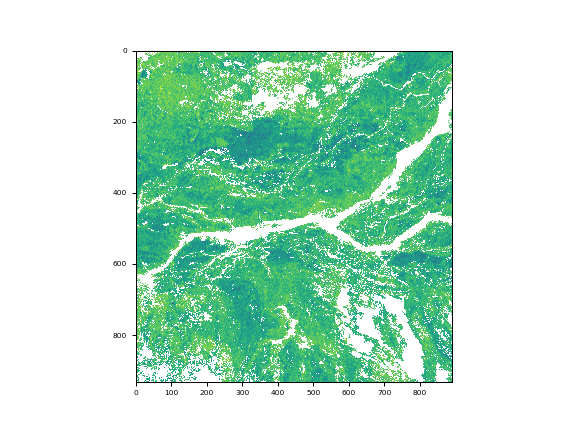

<xarray.Dataset>
Dimensions:  (time: 12, x: 891, y: 932)
Coordinates:
  * y        (y) float64 -2.009e+06 -2.009e+06 ... -1.986e+06 -1.986e+06
  * x        (x) float64 -7.163e+05 -7.163e+05 ... -7.385e+05 -7.385e+05
  * time     (time) datetime64[ns] 2017-01-01 2017-02-01 ... 2017-12-01
Data variables:
    Jan      (y, x) float32 0.81607676 0.8476633 nan 0.81917703 ... nan nan nan
    Feb      (y, x) float32 0.8663238 0.7982466 nan 0.81954443 ... nan nan nan
    Mar      (y, x) float32 0.824186 0.79750305 nan 0.7664587 ... nan nan nan
    Apr      (y, x) float32 0.76069105 0.7158977 nan 0.79358447 ... nan nan nan
    May      (y, x) float32 0.6961341 0.69519 nan 0.7759387 ... nan nan nan nan
    Jun      (y, x) float32 0.76816106 0.7113013 nan 0.7549137 ... nan nan nan
    Jul      (y, x) float32 0.75886583 0.70105636 nan 0.6537612 ... nan nan nan
    Aug      (y, x) float32 0.74631774 0.70597416 nan 0.67566 ... nan nan nan
    Sep      (y, x) float32 0.7235697 0.74004877 nan 0.6542484

In [50]:
import pandas as pd
time = pd.to_datetime(['2017-01-01','2017-02-01','2017-03-01','2017-04-01','2017-05-01','2017-06-01',
                             '2017-07-01','2017-08-01','2017-09-01','2017-10-01','2017-11-01','2017-12-01'])

monthly_mean_entropy=xr.Dataset({'Jan':(dp_grassland.entropy.sel(time=slice('2017-01-01', '2017-01-31')).mean(dim='time')), 'time': time})
monthly_mean_entropy['Feb']=dp_grassland.entropy.sel(time=slice('2017-02-01', '2017-02-28')).mean(dim='time')
monthly_mean_entropy['Mar']=dp_grassland.entropy.sel(time=slice('2017-03-01', '2017-03-31')).mean(dim='time')
monthly_mean_entropy['Apr']=dp_grassland.entropy.sel(time=slice('2017-04-01', '2017-04-30')).mean(dim='time')
monthly_mean_entropy['May']=dp_grassland.entropy.sel(time=slice('2017-05-01', '2017-05-31')).mean(dim='time')
monthly_mean_entropy['Jun']=dp_grassland.entropy.sel(time=slice('2017-06-01', '2017-06-30')).mean(dim='time')
monthly_mean_entropy['Jul']=dp_grassland.entropy.sel(time=slice('2017-07-01', '2017-07-31')).mean(dim='time')
monthly_mean_entropy['Aug']=dp_grassland.entropy.sel(time=slice('2017-08-01', '2017-08-31')).mean(dim='time')
monthly_mean_entropy['Sep']=dp_grassland.entropy.sel(time=slice('2017-09-01', '2017-09-30')).mean(dim='time')
monthly_mean_entropy['Oct']=dp_grassland.entropy.sel(time=slice('2017-10-01', '2017-10-31')).mean(dim='time')
monthly_mean_entropy['Nov']=dp_grassland.entropy.sel(time=slice('2017-11-01', '2017-11-30')).mean(dim='time')
monthly_mean_entropy['Dec']=dp_grassland.entropy.sel(time=slice('2017-12-01', '2017-12-31')).mean(dim='time')

# Display a monthly mean
fig = plt.figure()
plt.imshow(np.flip(monthly_mean_entropy.Nov), clim=(0,1.0))
monthly_mean_entropy

# Write output scenes to GeoTIFFs
## Output annual range and monthly mean RVI and Entropy images to GeoTIFF format

In [53]:
# write output images (in Albers) to GeoTIFF

import ogr, gdal, osr

# define coordinates for Albers equal area (3577)
xcoords = smoothed_grassland.isel(time=1).vv.indexes['x']
ycoords = smoothed_grassland.isel(time=1).vv.indexes['y']
yt,xt = smoothed_grassland.isel(time=1).vv.shape
MaxValX = xcoords.shape
MaxValY = ycoords.shape

# set geotransform and output projection
xres = 25 
yres = 25 
geotransform = (xcoords[MaxValX[0]-1]-(xres*0.5), xres, 0, ycoords[MaxValY[0]-1]+(yres*0.5), 0, -yres) # offset by half the pixel size since it needs to be top-left pixel coord
srs = osr.SpatialReference() 
srs.ImportFromEPSG(3577)

# loop through monthly images
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Edit output filenames (filename_RVI and filename_entropy) and directory as required
for month in months:
    
    filename_RVI = 'S1_RVI_Grasslands_Area1_3577_'+ month +'_'+ Year +'.tif' 
    S1_ds = gdal.GetDriverByName('GTiff').Create('/g/data/qd04/Cate/TempProcessing/'+filename_RVI, 
                                                   xt, yt, 1, gdal.GDT_Float32)
    S1_ds.SetGeoTransform(geotransform) # specify coordinates
    S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
    S1_ds.GetRasterBand(1).WriteArray(np.flip(monthly_mean_RVI[month]).data) # write band to raster
    S1_ds.FlushCache()  # write to file
    S1_ds = None # save and close
    
    filename_entropy = 'S1_Entropy_Grasslands_Area1_3577_'+ month + '_'+ Year + '.tif' 
    S1_ds = gdal.GetDriverByName('GTiff').Create('/g/data/qd04/Cate/TempProcessing/'+filename_entropy, 
                                                   xt, yt, 1, gdal.GDT_Float32)
    S1_ds.SetGeoTransform(geotransform) # specify coordinates
    S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
    S1_ds.GetRasterBand(1).WriteArray(np.flip(monthly_mean_entropy[month]).data) # write band to raster
    S1_ds.FlushCache()  # write to file
    S1_ds = None # save and close
    
# Output annual RVI and Entropy range images
filename_RVI = 'S1_RVI_Grasslands_Area1_3577_Annual_Range_' + Year +'.tif' 
S1_ds = gdal.GetDriverByName('GTiff').Create('/g/data/qd04/Cate/TempProcessing/'+filename_RVI, 
                                                   xt, yt, 1, gdal.GDT_Float32)
S1_ds.SetGeoTransform(geotransform) # specify coordinates
S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
S1_ds.GetRasterBand(1).WriteArray(np.flip(smoothed_grassland.RVI_range).data) # write band to raster
S1_ds.FlushCache()  # write to file
S1_ds = None # save and close

# Output annual RVI and Entropy range images
filename_entropy = 'S1_Entropy_Grasslands_Area1_3577_Annual_Range_' + Year + '.tif' 
S1_ds = gdal.GetDriverByName('GTiff').Create('/g/data/qd04/Cate/TempProcessing/'+filename_entropy, 
                                                   xt, yt, 1, gdal.GDT_Float32)
S1_ds.SetGeoTransform(geotransform) # specify coordinates
S1_ds.SetProjection(srs.ExportToWkt()) # export coords to file
S1_ds.GetRasterBand(1).WriteArray(np.flip(dp_grassland.entropy_range).data) # write band to raster
S1_ds.FlushCache()  # write to file
S1_ds = None # save and close